<a href="https://colab.research.google.com/github/Noel-May/bias-audit-healthcare-ml/blob/main/Bias_Audit_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
!pip install -q aif360


In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing


In [ ]:
# @title
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Healthcare Dataset")
X.head()


Healthcare Dataset


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# @title
np.random.seed(42)
X["gender"] = np.random.choice(["Male","Female"], size=len(X))


In [ ]:
# @title
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# @title
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

preds = model.predict(X_test)


In [ ]:
# @title
results = pd.DataFrame({
    "actual": y_test,
    "pred": preds,
    "gender": X.loc[y_test.index]["gender"].values
})

male = results[results["gender"]=="Male"]
female = results[results["gender"]=="Female"]

def approval_rate(g):
    return g["pred"].mean()

def tpr(g):
    tp = ((g["pred"]==1) & (g["actual"]==1)).sum()
    pos = (g["actual"]==1).sum()
    return tp/pos

spd = approval_rate(male) - approval_rate(female)
di = approval_rate(female) / approval_rate(male)
eod = tpr(male) - tpr(female)

print("FAIRNESS METRICS")
print("Statistical Parity Difference:", round(spd,3))
print("Disparate Impact:", round(di,3))
print("Equal Opportunity Difference:", round(eod,3))


FAIRNESS METRICS
Statistical Parity Difference: -0.045
Disparate Impact: 1.075
Equal Opportunity Difference: -0.002


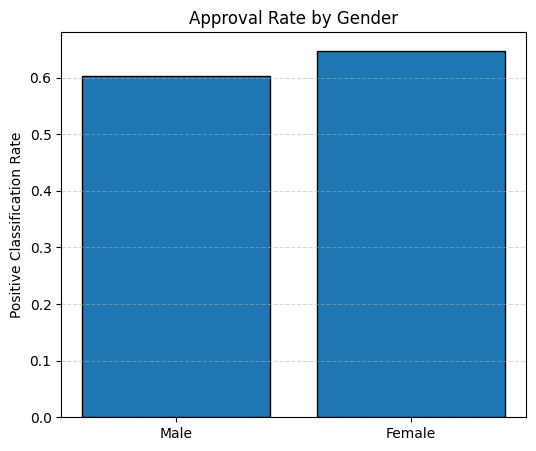

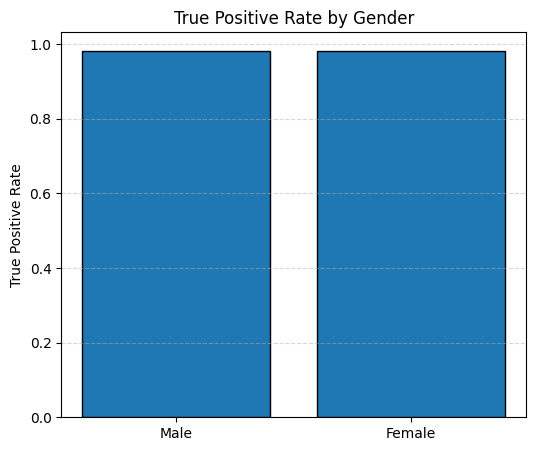

In [ ]:
# @title
plt.figure(figsize=(6,5))
plt.bar(
    ["Male","Female"],
    [approval_rate(male), approval_rate(female)],
    edgecolor="black"
)
plt.title("Approval Rate by Gender")
plt.ylabel("Positive Classification Rate")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(6,5))
plt.bar(
    ["Male","Female"],
    [tpr(male), tpr(female)],
    edgecolor="black"
)
plt.title("True Positive Rate by Gender")
plt.ylabel("True Positive Rate")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric


In [ ]:
# Create numeric-only copy for AIF360
aif_df = results.copy()

# Convert gender to numeric (0 = Female, 1 = Male)
aif_df["gender"] = aif_df["gender"].map({"Male":1, "Female":0})

# Ensure all columns are numeric
aif_df = aif_df.select_dtypes(include=["number"])

print("Numeric DataFrame for AIF360 ready")
print(aif_df.head())



Numeric DataFrame for AIF360 ready
     actual  pred  gender
204       1     1       0
70        0     0       0
131       0     0       1
431       1     1       0
540       1     1       1


In [ ]:
# Build numeric-only copy for AIF360 (NO TEXT ALLOWED)
aif_df = results.copy()

# Convert gender
aif_df["gender"] = aif_df["gender"].map({"Male":1, "Female":0})

# Drop any accidental leftover non-numeric columns if present
aif_df = aif_df.select_dtypes(include=["number"])

print("Remaining columns for AIF360:")
print(aif_df.columns.tolist())


Remaining columns for AIF360:
['actual', 'pred', 'gender']


In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

# Build true dataset
true_dataset = BinaryLabelDataset(
    df=aif_df,
    label_names=['actual'],
    protected_attribute_names=['gender']
)

# Build predicted dataset (must be float)
pred_dataset = true_dataset.copy()
pred_dataset.labels = aif_df['pred'].values.reshape(-1,1).astype(float)

# Calculate fairness metrics
clf_metric = ClassificationMetric(
    true_dataset,
    pred_dataset,
    unprivileged_groups=[{'gender':0}],   # Female
    privileged_groups=[{'gender':1}]      # Male
)

print("\nFAIRNESS METRICS")
print("SPD:", round(clf_metric.statistical_parity_difference(),3))
print("DI:", round(clf_metric.disparate_impact(),3))
print("EOD:", round(clf_metric.equal_opportunity_difference(),3))



print("SPD:", round(clf_metric.statistical_parity_difference(),3))
print("DI:", round(clf_metric.disparate_impact(),3))
print("EOD:", round(clf_metric.equal_opportunity_difference(),3))



FAIRNESS METRICS
SPD: 0.045
DI: 1.075
EOD: 0.002
SPD: 0.045
DI: 1.075
EOD: 0.002


In [ ]:
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn.linear_model import LogisticRegression

# ------------------------------
# Keep original gender column
# ------------------------------
# If 'gender' column is missing from X (due to previous cell issues or overwriting), re-add it.
# This assumes the original data and random seed for gender assignment.
if "gender" not in X.columns:
    # Recreate the gender series deterministically using the original seed and length of X
    np.random.seed(42)
    original_gender_series = pd.Series(np.random.choice(["Male","Female"], size=len(X)), index=X.index)
    gender_to_split = original_gender_series
else:
    # If gender is present, use it as intended
    gender_to_split = X["gender"].copy()

# Split dataset
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X_encoded, y, gender_to_split, test_size=0.3, random_state=42
)

# ------------------------------
# Build training DataFrame for AIF360
# ------------------------------
train_df = pd.DataFrame({
    "actual": y_train,
    "gender": gender_train
})

# Convert gender to numeric
train_df["gender"] = train_df["gender"].map({"Male":1,"Female":0})

# Build BinaryLabelDataset for training
train_dataset = BinaryLabelDataset(
    df=train_df,
    label_names=['actual'],
    protected_attribute_names=['gender']
)

# Apply Reweighing
rw = Reweighing(
    unprivileged_groups=[{'gender':0}],  # Female
    privileged_groups=[{'gender':1}]     # Male
)
rw_train = rw.fit_transform(train_dataset)

print("Reweighing applied. Sample weights for training:")
print(rw_train.instance_weights[:10])

# ------------------------------
# Train model with instance weights
# ------------------------------
# Increased max_iter to prevent ConvergenceWarning
model_rw = LogisticRegression(max_iter=5000)
model_rw.fit(X_train, y_train, sample_weight=rw_train.instance_weights)

# Predict on test set
preds_rw = model_rw.predict(X_test)

# ------------------------------
# Build test results DataFrame
# ------------------------------
results_rw = pd.DataFrame({
    "actual": y_test,
    "pred": preds_rw,
    "gender": gender_test
})

# Convert gender to numeric for AIF360
results_rw["gender_num"] = results_rw["gender"].map({"Male":1,"Female":0})

# Prepare numeric-only DataFrame for AIF360
aif_df_rw = results_rw.copy()
aif_df_rw["gender"] = aif_df_rw["gender_num"]
aif_df_rw = aif_df_rw.select_dtypes(include=["number"])

# Build BinaryLabelDataset for test set
true_dataset_rw = BinaryLabelDataset(
    df=aif_df_rw,
    label_names=['actual'],
    protected_attribute_names=['gender']
)
pred_dataset_rw = true_dataset_rw.copy()
pred_dataset_rw.labels = aif_df_rw['pred'].values.reshape(-1,1).astype(float)

# ------------------------------
# Compute post-mitigation metrics
# ------------------------------
clf_metric_rw = ClassificationMetric(
    true_dataset_rw,
    pred_dataset_rw,
    unprivileged_groups=[{'gender':0}],
    privileged_groups=[{'gender':1}]
)

print("\nFAIRNESS METRICS AFTER REWEIGHING")
print("SPD:", round(clf_metric_rw.statistical_parity_difference(),3))
print("DI:", round(clf_metric_rw.disparate_impact(),3))
print("EOD:", round(clf_metric_rw.equal_opportunity_difference(),3))

Reweighing applied. Sample weights for training:
[0.97635907 1.02667182 0.97635907 0.97635907 0.97635907 1.04217031
 0.97635907 1.02667182 0.97635907 1.02667182]

FAIRNESS METRICS AFTER REWEIGHING
SPD: 0.068
DI: 1.113
EOD: 0.039


Accuracy Comparison
Accuracy Before Mitigation: 0.982
Accuracy After Mitigation: 0.971

Fairness Metrics Comparison
Statistical Parity Difference (SPD): Before = 0.045, After = 0.068
Disparate Impact (DI): Before = 1.075, After = 1.113
Equal Opportunity Difference (EOD): Before = 0.002, After = 0.039


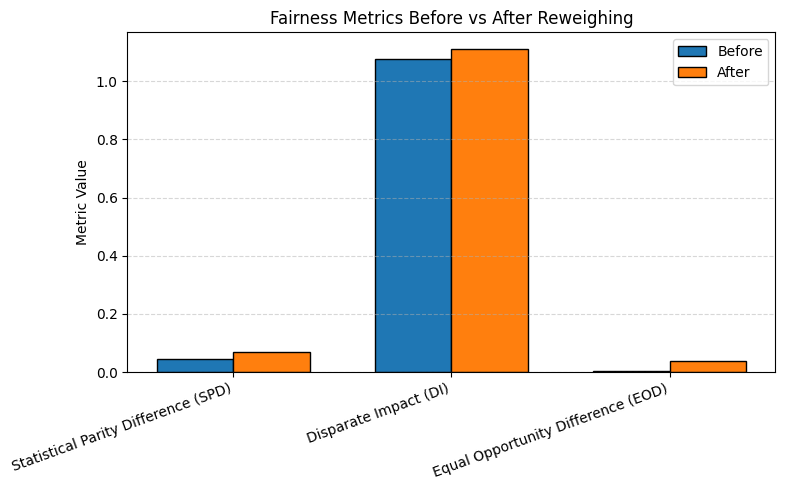

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ------------------------------
# Accuracy Comparison
# ------------------------------
acc_before = accuracy_score(y_test, preds)
acc_after = accuracy_score(y_test, preds_rw)

print("Accuracy Comparison")
print("Accuracy Before Mitigation:", round(acc_before, 3))
print("Accuracy After Mitigation:", round(acc_after, 3))

# ------------------------------
# Fairness Metrics Comparison
# ------------------------------
metrics = ['Statistical Parity Difference (SPD)',
           'Disparate Impact (DI)',
           'Equal Opportunity Difference (EOD)']

before_values = [
    clf_metric.statistical_parity_difference(),
    clf_metric.disparate_impact(),
    clf_metric.equal_opportunity_difference()
]

after_values = [
    clf_metric_rw.statistical_parity_difference(),
    clf_metric_rw.disparate_impact(),
    clf_metric_rw.equal_opportunity_difference()
]

# Print metrics
print("\nFairness Metrics Comparison")
for m, b, a in zip(metrics, before_values, after_values):
    print(f"{m}: Before = {round(b,3)}, After = {round(a,3)}")

# ------------------------------
# Visual Comparison: Bar Chart
# ------------------------------
import numpy as np

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, before_values, width, label='Before', edgecolor='black')
plt.bar(x + width/2, after_values, width, label='After', edgecolor='black')

plt.xticks(x, metrics, rotation=20, ha='right')
plt.ylabel('Metric Value')
plt.title('Fairness Metrics Before vs After Reweighing')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
